In [6]:
import cv2
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D, concatenate
from keras.layers.core import Dropout
from keras.optimizers import Adadelta, SGD, Adam
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from data import load_train_data, load_test_data, load_validation_data

img_rows = 64
img_cols = 96
smooth = 1

In [3]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
  
def jacc_coef(y_true, y_pred, smooth = smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    
def jacc_loss(y_true, y_pred):
    return -jacc_coef(y_true, y_pred)

def get_unet(optimizer, loss, dropout):
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Convolution2D(64, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(inputs)
    conv1 = Convolution2D(64, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(128, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(pool1)
    conv2 = Convolution2D(128, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(256, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(pool2)
    conv3 = Convolution2D(256, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(512, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(pool3)
    conv4 = Convolution2D(512, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(1024, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(pool4)
    conv5 = Dropout(dropout)(conv5)
    conv5 = Convolution2D(1024, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv5)
    conv5 = Dropout(dropout)(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv05 = Convolution2D(2048, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(pool5)
    conv05 = Dropout(dropout)(conv05)
    conv05 = Convolution2D(2048, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv05)
    conv05 = Dropout(dropout)(conv05)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv05), conv5])
    conv6 = Convolution2D(1024, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(up6)
    conv6 = Dropout(dropout)(conv6)
    conv6 = Convolution2D(1024, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv6)
    conv6 = Dropout(dropout)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv4])
    conv7 = Convolution2D(512, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(up7)
    conv7 = Convolution2D(512, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv3])
    conv8 = Convolution2D(256, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(up8)
    conv8 = Convolution2D(256, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv2])
    conv9 = Convolution2D(128, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(up9)
    conv9 = Convolution2D(128, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv9)

    up10 = concatenate([UpSampling2D(size=(2, 2))(conv9), conv1])
    conv09 = Convolution2D(64, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(up10)
    conv09 = Convolution2D(64, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv09)

    conv10 = Convolution2D(1, (1, 1), activation='sigmoid')(conv09)

    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=optimizer, loss=loss, metrics=[dice_coef, jacc_coef])
    return model

def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], imgs.shape[1], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i, 0]  = cv2.resize(imgs[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_AREA)
    return imgs_p

def swap_axes(imgs):
    return np.swapaxes(np.swapaxes(imgs, 1, 2), 2, 3)
  
def resume_learning(model, resume):
    if not resume:
      if(os.path.exists(model_filename)):
        os.remove(model_filename)
    else:
      if(os.path.exists(model_filename)):
          model.load_weights(model_filename)

In [4]:
imgs_train, imgs_mask_train = load_train_data()
imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train) 
std = np.std(imgs_train) 

In [7]:
batch_size = 128
n_steps = (int)(len(imgs_train)/batch_size)
optimizer = SGD(lr=0.015, momentum=0.45, decay=0.0, nesterov=False)
loss = jacc_loss
epochs, completed_epochs = 400, 300
dropout = 0.05
model_filename = r"C:\Users\ChiaWei\Google Drive\unet_49.hdf5"

model = get_unet(optimizer, loss, dropout)
model_checkpoint = ModelCheckpoint(model_filename, monitor='loss', save_best_only=True)
if(os.path.exists(model_filename)):
    model.load_weights(model_filename)

In [8]:
imgs_test, imgs_mask_test = load_test_data()
imgs_test_processed = preprocess(imgs_test)
imgs_test_processed = imgs_test_processed.astype('float32')
imgs_test_processed -= mean
imgs_test_processed /= std
imgs_test_processed = swap_axes(imgs_test_processed)

In [9]:
def predict_image(index):
    pred = model.predict(imgs_test_processed[index:index+1])
    pred_mask = np.where(pred > 0.5, 0, 1)[0,:,:,0]
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(18, 6), nrows=1, ncols=4)
    
    img1 = imgs_test[index, 0, :, :]
    title1 = 'Test Image [{}]'.format(index) + '\n' + \
             'Dimension : {}'.format(img1.shape)
    ax1.imshow(img1, cmap='gray')
    ax1.set_title(title1)
    
    img2 = imgs_mask_test[index, 0, :, :]
    title2 = 'Test Image Mask [{}]'.format(index) + '\n' + \
             'Dimension : {}'.format(img2.shape)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2)
    
    img3 = pred_mask
    title3 = 'Test Image Mask Prediction [{}]'.format(index) + '\n' + \
             'Dimension : {}'.format(img3.shape)
    ax3.imshow(img3, cmap='gray')
    ax3.set_title(title3)
    
    img4 = cv2.resize(pred_mask.astype(np.float32), (img2.shape[1], img2.shape[0]), interpolation=cv2.INTER_AREA)
    title4 = 'Test Image Mask Prediction [{}] (Resized)'.format(index) + '\n' + \
             'Dimension : {}'.format(img4.shape)
    ax4.imshow(img4, cmap='gray')
    ax4.set_title(title4)
    
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

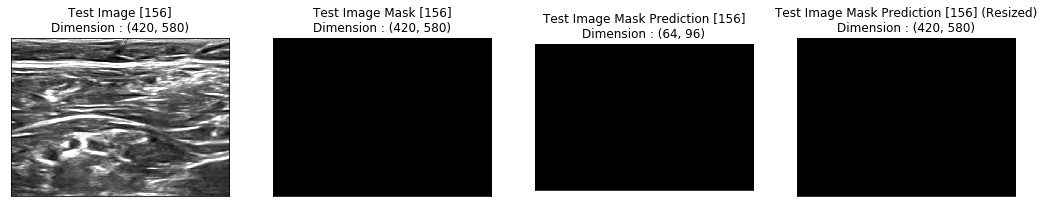

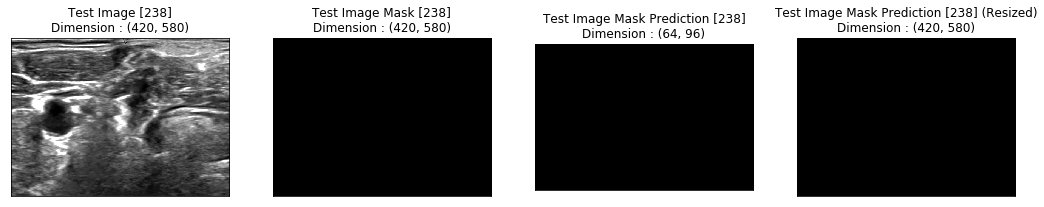

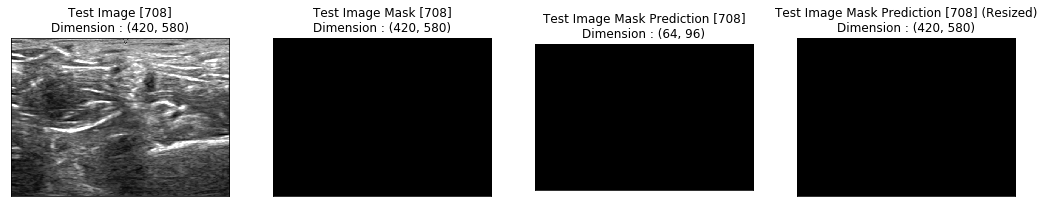

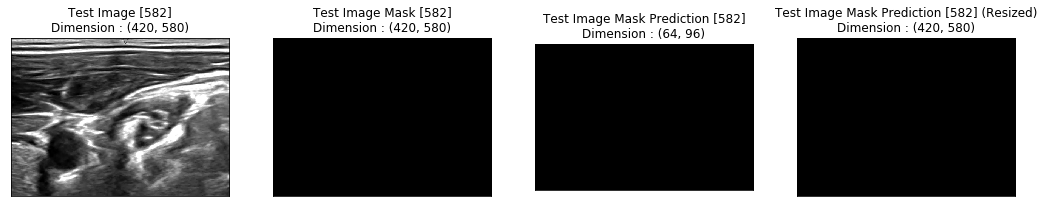

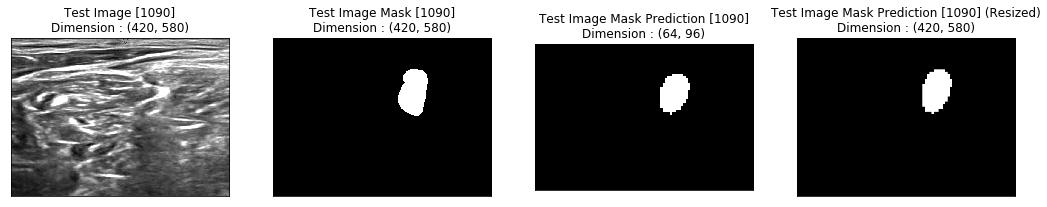

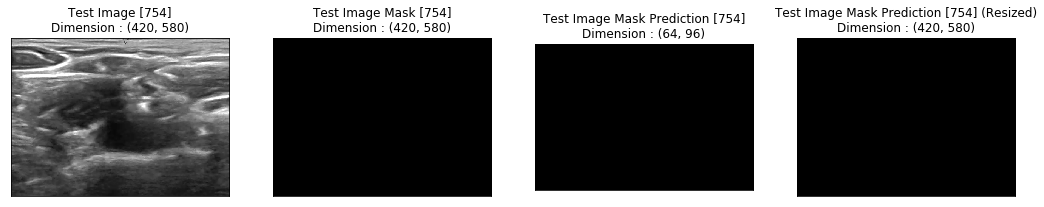

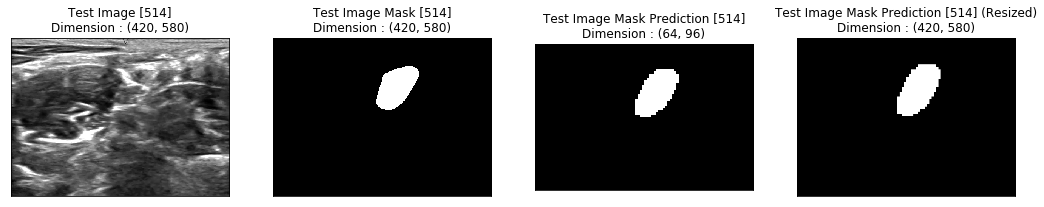

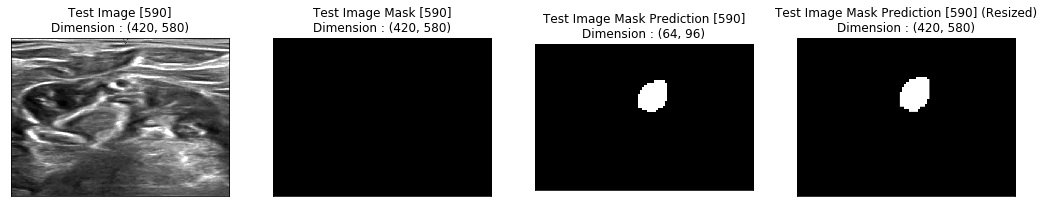

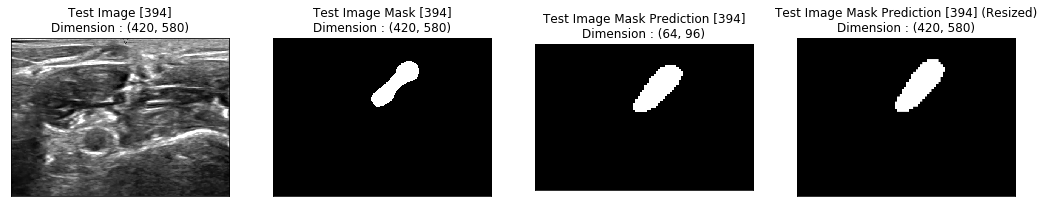

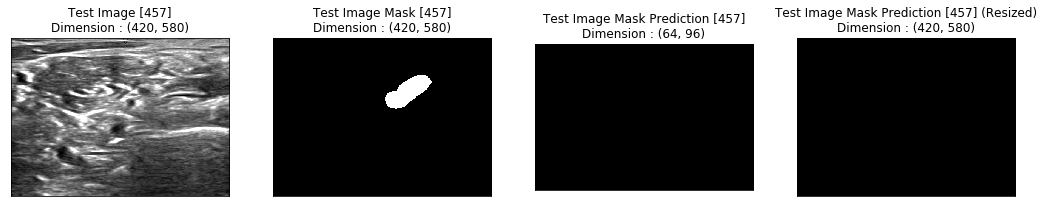

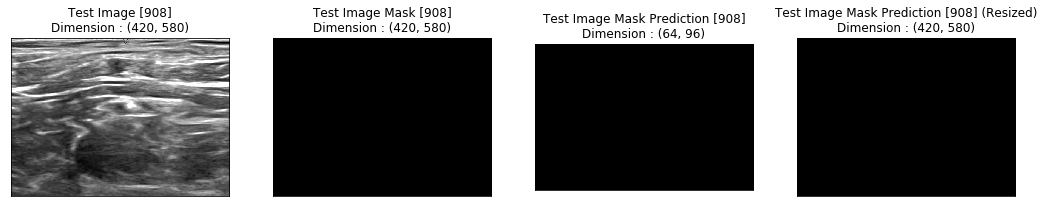

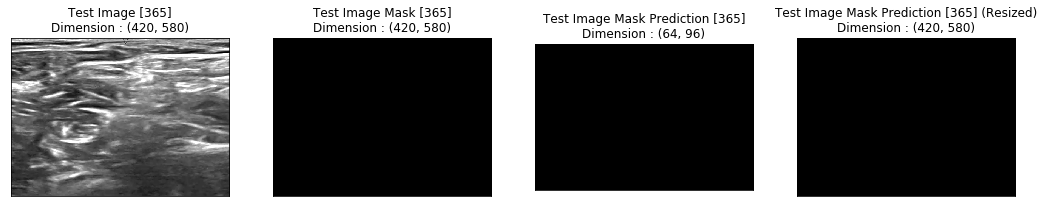

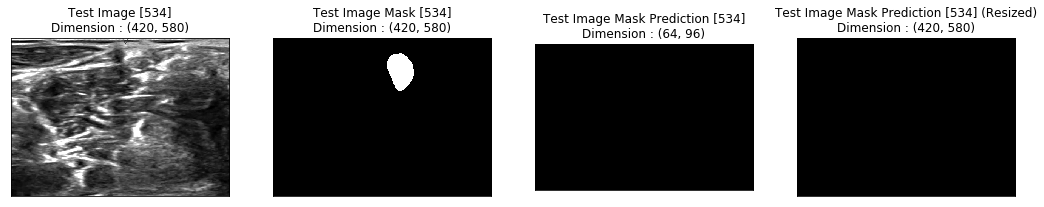

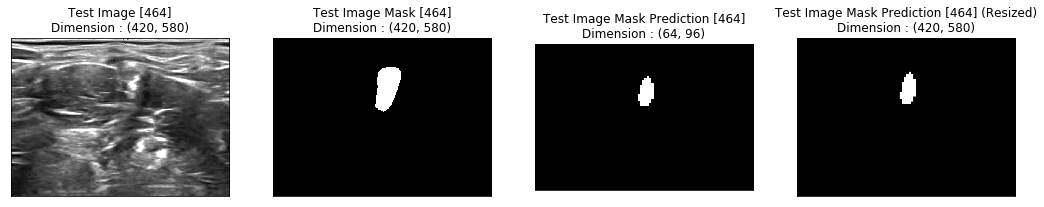

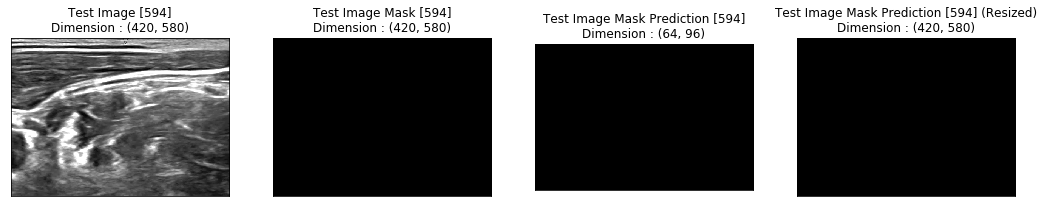

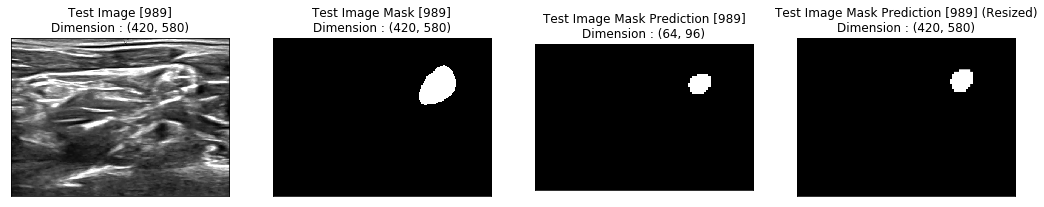

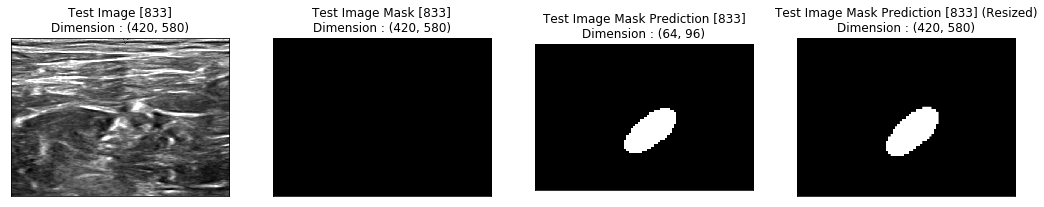

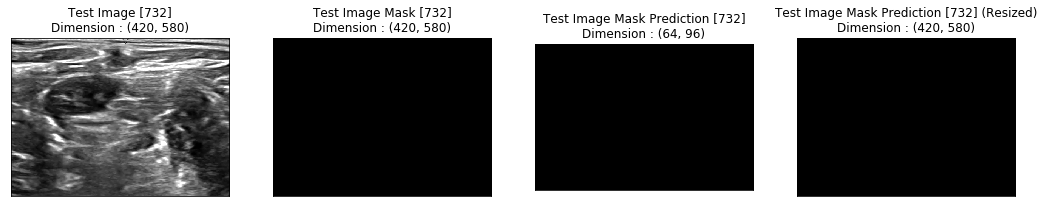

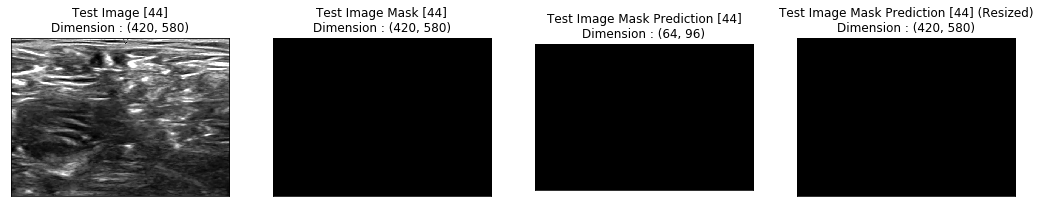

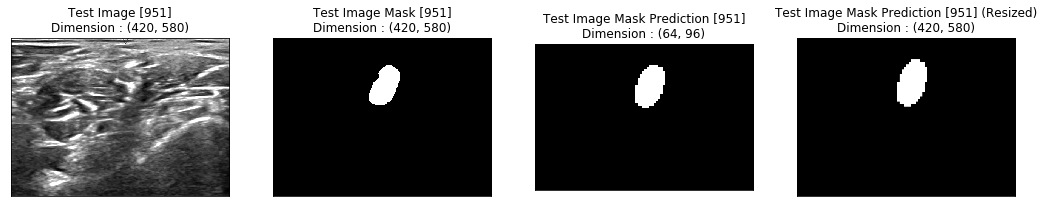

In [23]:
for n in np.random.choice(imgs_test.shape[0], 20):
    predict_image(n)